## 「ベイズ推論による機械学習入門
##   P.137 ポアソン混合モデルに対する崩壊型ギブスサンプリング

In [2]:
using Distributions
using Plots
using StatsBase
using StatsFuns
using SpecialFunctions: loggamma

const lnΓ = loggamma;

## 真のモデル

In [3]:
λ_true = [10.0, 25.0, 40.0]
π_true = [0.35, 0.3, 0.35]
true_model = MixtureModel([Poisson(λ) for λ in λ_true], π_true)

MixtureModel{Poisson{Float64}}(K = 3)
components[1] (prior = 0.3500): Poisson{Float64}(λ=10.0)
components[2] (prior = 0.3000): Poisson{Float64}(λ=25.0)
components[3] (prior = 0.3500): Poisson{Float64}(λ=40.0)


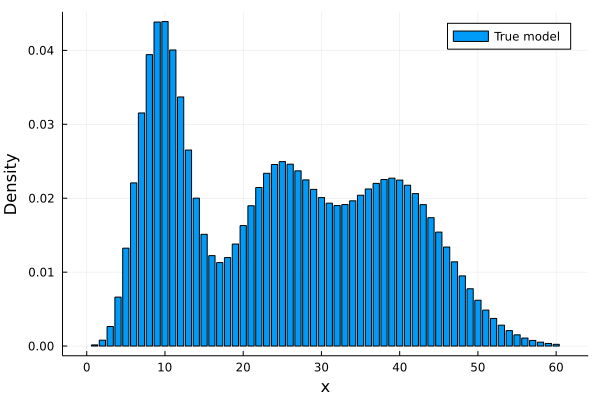

In [4]:
bar(x -> pdf(true_model, x), 1:60, label="True model", xlabel="x", ylabel="Density")

## 観測データを生成

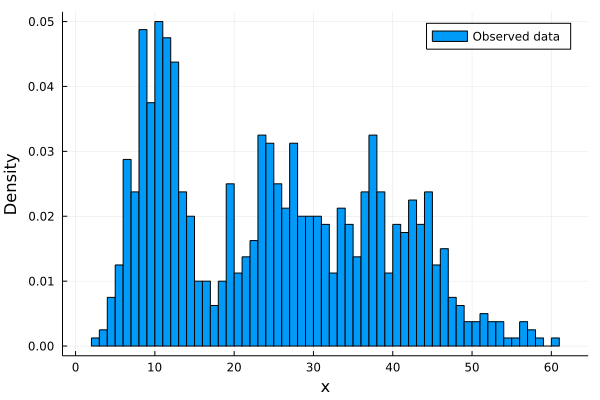

In [5]:
N = 800
mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

data = Float64[]
for (idx, val) in enumerate(λ_true)
    n = count(cluster_num .== idx)
    poi_obs = Poisson(val)
    data = vcat(data, rand(poi_obs, n))
end

bins = 80
histogram(data; bins, label="Observed data", xlabel="x", ylabel="Density", norm=:pdf)

## 崩壊型ギブスサンプリング

In [39]:
N = 800
K = 3;

### 潜在変数のサンプルに初期値を設定

In [40]:
α̂ = ones(K)
E_π = α̂ ./ sum(α̂)
S_sample = rand(Multinomial(1, E_π), N)

3×800 Matrix{Int64}:
 0  0  0  0  0  0  0  0  1  1  0  1  1  …  0  0  1  0  1  1  0  0  1  0  0  1
 0  1  1  0  1  1  1  0  0  0  0  0  0     1  1  0  0  0  0  0  1  0  0  1  0
 1  0  0  1  0  0  0  1  0  0  1  0  0     0  0  0  1  0  0  1  0  0  1  0  0

### パラメータを計算

In [41]:
â = ones(K)
b̂ = ones(K)
â += vec(sum(S_sample .* data', dims=2))
b̂ += vec(sum(S_sample, dims=2))
α̂ += vec(sum(S_sample, dims=2))
@show â
@show b̂
@show α̂;

â = [7025.0, 6638.0, 5933.0]
b̂ = [280.0, 267.0, 256.0]
α̂ = [280.0, 267.0, 256.0]


### パラメータより$x_{n}$に関する統計量を除去

具体的に1つ目のデータで以後の計算してみる。


In [42]:
cluster_num = vec(mapslices(argmax, S_sample, dims=1))
â[cluster_num[1]] = â[cluster_num[1]] - data[1]
b̂[cluster_num[1]] = b̂[cluster_num[1]] - 1 # sₙₖ = 1
α̂[cluster_num[1]] = α̂[cluster_num[1]] - 1
@show â
@show b̂
@show α̂;

â = [7025.0, 6638.0, 5921.0]
b̂ = [280.0, 267.0, 255.0]
α̂ = [280.0, 267.0, 255.0]


### 潜在変数の事後分布を計算とサンプリング

In [43]:
r̂ = â
p̂ = 1 ./ (b̂ .+ 1)
nb = NegativeBinomial.(r̂, 1 .- p̂)

3-element Vector{NegativeBinomial{Float64}}:
 NegativeBinomial{Float64}(r=7025.0, p=0.99644128113879)
 NegativeBinomial{Float64}(r=6638.0, p=0.996268656716418)
 NegativeBinomial{Float64}(r=5921.0, p=0.99609375)

In [44]:
prob_nb = pdf.(nb, data[1])

3-element Vector{Float64}:
 0.0016683761223783714
 0.001878443993985898
 0.004265164353781153

In [45]:
η = α̂ ./ sum(α̂)
prob_s_ = prob_nb .* η
prob_s = prob_s_ ./ sum(prob_s_) # 正規化

3-element Vector{Float64}:
 0.22717685944656338
 0.24390550743601863
 0.528917633117418

In [46]:
cat = Multinomial(1, prob_s)
s₁ = rand(cat)
ans = cluster_num[1]
@show s₁
@show ans

3-element Vector{Int64}:
 0
 0
 1

### 対数尤度から計算する場合

In [60]:
# Distributions.jiを使うパターン
tmp_prob_s = exp.(loglikelihood.(nb, data[1]) .+ log.(η)) ./ sum(exp.(loglikelihood.(nb, data[1]) .+ log.(η)))
tmp_cat = Multinomial(1, tmp_prob_s)
tmp_s = rand(tmp_cat)
@show tmp_prob_s
@show tmp_s;

tmp_prob_s = [0.22717685944656343, 0.2439055074360186, 0.528917633117418]
tmp_s = [0, 0, 1]


In [77]:
# 式から計算するパターン
ln_nb = lnΓ.(r̂ .+ data[1]) .- log(factorial(data[1])) .- lnΓ.(r̂) .+ data[1] .* log.(1 .- p̂) .+ r̂ .* log.(p̂)
ln_s_ = ln_nb .+ log.(η)
ln_s = ln_s .- logsumexp(ln_s)
tmp_prob_ln_s = exp.(ln_s) ./ sum(exp.(ln_s))
tmp_cat2 = Multinomial(1, tmp_prob_ln_s)
tmp_s2 = rand(tmp_cat2)

3-element Vector{Int64}:
 0
 0
 1

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [ ]:
N = 800
K = 3
max_iter = 100

s_sample = zeros(K, N)
λ_sample = zeros(max_iter+1, K)
π_sample = zeros(max_iter+1, K)

λ_sample[1, :] = rand(K) .* (maximum(data) - minimum(data)) .+ minimum(data)
p = rand(K)
π_sample[1, :] = p ./ sum(p)
â = ones(K)
b̂ = ones(K)
α̂ = ones(K)

η_ = zeros(K, N)

for i in 1:max_iter
    # 代入の際に .= を用いることで、ループが始まる前に確保した η_ の領域をループの際に使い回すことができる
    η_ .= exp.(data' .* log.(λ_sample[i, :]) .- λ_sample[i, :] .+ π_sample[i, :])
    η = η_ ./ sum(η_, dims=1)
    for n in 1:N
        cat = Multinomial(1, η[:, n])
        s_sample[:, n] = rand(cat)
    end
　　　
    â += vec(sum(s_sample .* data', dims=2))
    b̂ += vec(sum(s_sample, dims=2))
    for k in 1:K
        gam = Gamma(â[k], 1 ./ b̂[k])
        λ_sample[i+1, k] = rand(gam)[1]
    end
　　
    α̂ += vec(sum(s_sample, dims=2))
    dir = Dirichlet(α̂)
    π_sample[i+1, :] = rand(dir, 1)
    
    if i % 10 == 1
        println("iteration: $i")
    end
    
    # s_sample を構成する全ての要素をゼロに置き換える
    fill!(s_sample, zero(eltype(s_sample)))
    
end

In [82]:
r = 3
p = 0.5
nb = NegativeBinomial(r, p)

NegativeBinomial{Float64}(r=3.0, p=0.5)

In [87]:
lkh = loglikelihood.(nb, 1:10)

10-element Vector{Float64}:
 -1.6739764335716711
 -1.6739764335716716
 -1.8562979903656256
 -2.143980062817408
 -2.500655006756138
 -2.9061201148643026
 -3.347952867143338
 -3.817956496389078
 -4.310432981486871
 -4.821258605252862

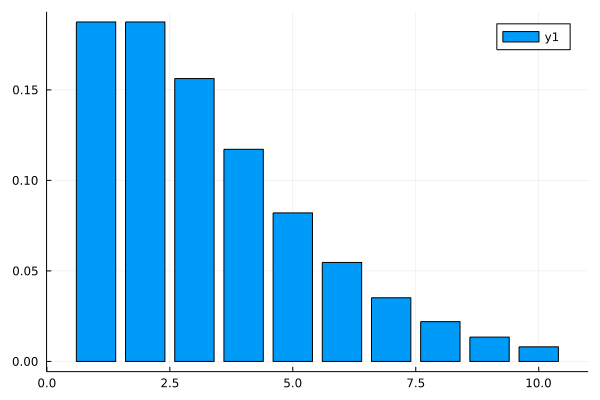

In [89]:
bar(1:10, exp.(lkh))